# Figure 4: Example of ChirpEye's differential circuitry signals.

In [1]:
from utils import *

color_map = sns.color_palette("cubehelix", 3).as_hex()
sns.set_theme(style="whitegrid")

expected peaks at: (58812.080536912756, 20456.375838926175, 38355.70469798658)


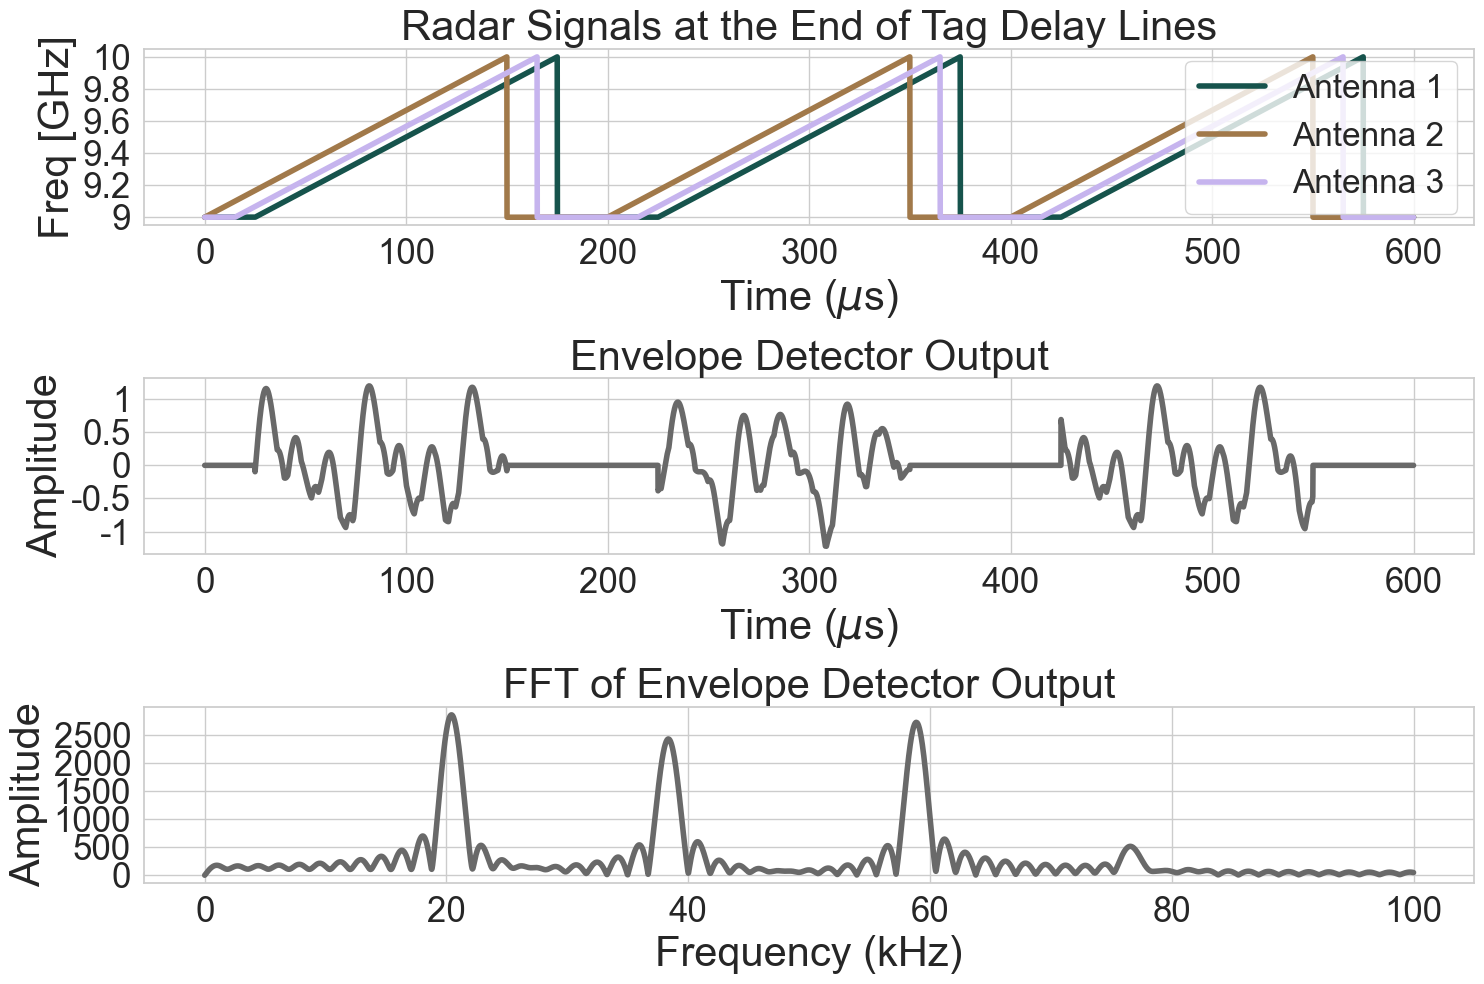

In [2]:
def get_bf_gt(cable_length, band_width, period):
    inch2meter = 0.0254
    c = 2.98e8

    slope = band_width / period

    length = cable_length*inch2meter 
    speed_signal = c*2/3

    control_delay = length / speed_signal
    f_beat = control_delay * slope

    return f_beat

# defining the delay function
def delay_signal(signal, t, T_sample, zero_start = False):
    num_points = int(t / T_sample)
    delayed_signal = np.roll(signal, num_points)
    delayed_signal[0:num_points] = 0 if zero_start else signal[0]
    return delayed_signal

################################### Parameter Definitions ##################################
chirp_dur_ = 150
band_width_ = 1000
delay_ = 50

chirp_dur = chirp_dur_ * 1e-6
band_width = band_width_ * 1e6
delay = delay_ * 1e-6

period = chirp_dur+delay
f_0 = 9 * 1e9

cable_len = 72 - 3
cable_len1 = 72 - 48
cable_len2 = 48 - 3

fs = 20e6
T_sample = 1/fs
size = 400 * 30

t = np.linspace(0, T_sample * size, size)

# FMCW frequency domain signal
def f_t(t, f_0, band_width, chirp_dur, period):
    m_w = band_width/chirp_dur
    return f_0 + np.array([m_w*(t_sample % period) if t_sample % period < chirp_dur else 0 for t_sample in t])

FMCW_freq = f_t(t, f_0, band_width, chirp_dur, period)
FMCW_freq1 = f_t(t, f_0, band_width, chirp_dur/1.5, period)
FMCW_freq2 = FMCW_freq

length = cable_len * 0.0254 # inch to meters
speed_signal = c * speed_ratio

control_delay = length / speed_signal

TOF = control_delay
FMCW_freq_delay = delay_signal(FMCW_freq, 15e-6, T_sample)
FMCW_freq_delay1 = delay_signal(FMCW_freq, 25e-6, T_sample)

################################ modeling time domain signal ####################################
exp_freq = get_bf_gt(cable_length=cable_len, band_width=band_width, period= chirp_dur)
exp_freq1 = get_bf_gt(cable_length=cable_len1, band_width=band_width, period= chirp_dur)
exp_freq2 = get_bf_gt(cable_length=cable_len2, band_width=band_width, period= chirp_dur)

print(f"expected peaks at: {exp_freq, exp_freq1, exp_freq2}")

out_sig0 = np.abs(np.sin(2*np.pi*exp_freq*t) + 0.8)
out_sig1 = np.abs(np.sin(2*np.pi*exp_freq1*t) + 0.9)
out_sig2 = np.abs(np.sin(2*np.pi*exp_freq2*t) + 0.7)

out_sig = out_sig0 + out_sig1 + out_sig2
out_sig_mock = np.sin(2*np.pi*exp_freq*t) + np.sin(2*np.pi*exp_freq1*t) + np.sin(2*np.pi*exp_freq2*t)

duty_cycle = (chirp_dur-25e-6) / period
out_square = (signal.square(2*np.pi*1/period * t, duty=duty_cycle)+1)/2

out_sig = (out_sig - np.mean(out_sig)) / 2

exp_x = out_sig*out_square

freq_diff = np.abs(FMCW_freq-FMCW_freq_delay)
condition = (np.arange(len(freq_diff)) % 3000 > 200) & (np.arange(len(freq_diff)) % 3000 < 2000)
freq_diff[condition] = 0
inter_chirp_signal = np.abs(np.sin(2*np.pi*freq_diff*t))

exp_x = delay_signal(exp_x, 25e-6, T_sample, zero_start=True) #+ inter_chirp_signal

################################ FFT spectrum of signal ####################################
out_sig_sum = out_sig #+ out_sig1

w, H = zoom_fft(out_sig - np.mean(out_sig), fs=20e6, max_freq=10e4, nfft=2**12)
peaks, _ = signal.find_peaks(np.abs(H), height=2000)

################################ Plotting ####################################
# Create a 2x1 grid for the subplots
fig = plt.figure(figsize=(15, 10))
gs = matplotlib.gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])  # Specify the height ratios for the subplots

# Upper subplot (index 0)
ax1 = fig.add_subplot(gs[0])
ax1.plot(t*1e6, FMCW_freq_delay1, label='Antenna 1', color=color_map[0], linewidth=4)
ax1.plot(t*1e6, FMCW_freq, label='Antenna 2', color=color_map[1], linewidth=4)
ax1.plot(t*1e6, FMCW_freq_delay, label='Antenna 3', color=color_map[2], linewidth=4)
ax1.set_xlabel('Time ($\\mu$s)', fontsize=30)
ax1.set_ylabel('Freq [GHz]', fontsize=30)
ax1.set_yticks([9e9, 9.2e9, 9.4e9, 9.6e9, 9.8e9, 10e9], [9, 9.2, 9.4, 9.6, 9.8, 10], fontsize=25)
ax1.set_xticks([0, 100, 200, 300, 400, 500, 600], [0, 100, 200, 300, 400, 500, 600], fontsize=25)
ax1.set_title("Radar Signals at the End of Tag Delay Lines", fontsize=30)
ax1.grid(which='major')
ax1.grid(True)
ax1.legend(fontsize=24)

# Upper subplot (index 1)
ax2 = fig.add_subplot(gs[1])
ax2.plot(t*1e6, exp_x, label='antenna 1', color='dimgrey', linewidth=4)
ax2.set_xlabel('Time ($\\mu$s)', fontsize=30)
ax2.set_ylabel('Amplitude', fontsize=30)
ax2.set_yticks([-1, -0.5, 0, 0.5, 1],[-1, -0.5, 0, 0.5, 1],fontsize=25)
ax2.set_xticks([0, 100, 200, 300, 400, 500, 600], [0, 100, 200, 300, 400, 500, 600], fontsize=25)
ax2.set_title("Envelope Detector Output", fontsize=30)
ax2.grid(which='major')
ax2.grid(True)

# Upper subplot (index 2)
ax3 = fig.add_subplot(gs[2])
ax3.plot(w, np.abs(H), label='FFT output', color='dimgrey', linewidth=4)
ax3.set_xlabel('Frequency (kHz)', fontsize=30)
ax3.set_ylabel('Amplitude', fontsize=30)
ax3.set_title("FFT of Envelope Detector Output", fontsize=30)
ax3.set_yticks([0, 500, 1000, 1500, 2000, 2500], [0, 500, 1000, 1500, 2000, 2500], fontsize=25)
ax3.set_xticks([0, 20000, 40000, 60000, 80000, 100000], [0, 20, 40, 60, 80, 100], fontsize=25)
ax3.grid(which='major')
ax3.grid(True)

plt.tight_layout()  # Adjust layout to prevent overlapping